In [1]:
from pandas import read_excel
import numpy as np
from numpy.linalg import eigh
import scipy as sp
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.pyplot.ion()
%matplotlib inline 
import pickle

from qlp.mds import graph_tools as gt
from qlp.mds.qubo import get_mds_qubo
from qlp.mds.mds_qlpdb import QUBO_to_Ising, find_offset, AnnealOffset

from qlp.tdse import (
    s_to_offset,
    AnnealSchedule,
    plot_anneal_schedule,
    TDSE,
    embed_qubo_example,
)

import networkx as nx
from networkx import Graph
from networkx.drawing.nx_pylab import draw

-0.0


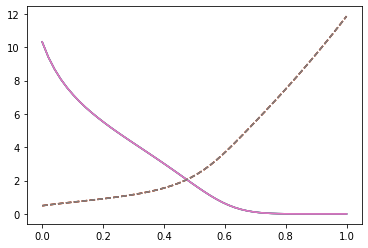

dE [    0.          3721.87885579  3785.95460641  3898.58904617
  4195.56705014  7617.37722106  7617.41666973  7617.41666973
  7802.65356712  7987.04097975  8172.09173002 11512.95448366
 11592.52676426 11709.65922353 12008.24428052 15611.45252881]
pr [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] total 1.0
Num. degenerate states @ s=1: 2
final total prob 0.9904477254577834
Num. degenerate states @ s=1: 2
-0.05


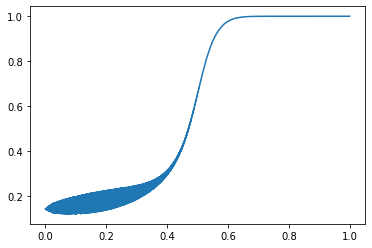

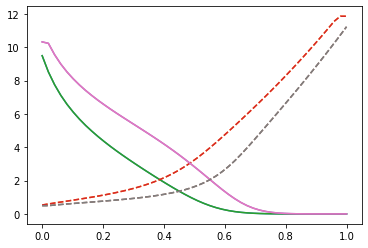

dE [    0.          3397.42687305  3649.62281434  3898.8652776
  4037.98284421  7121.10939214  7292.96468698  7292.96468698
  7603.75595212  7693.89024649  7957.66057113 11029.73266973
 11093.73087836 11188.50250092 11662.98509578 14996.60986791]
pr [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] total 1.0
Num. degenerate states @ s=1: 2
final total prob 0.9906404566370599
Num. degenerate states @ s=1: 2


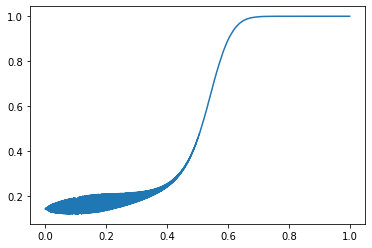

In [5]:
# brute force solving time-dependent schrodinger equation to simulate quantum annealing for small systems
result = dict()
offset_min_list = -0.05 * np.arange(2)
for offset_min in offset_min_list:
    print(offset_min)
    nvertices = 2
    graph, tag = gt.generate_nn_graph(nvertices)
    penalty = 2
    embed = False  # nvertices = [2] available

    annealing_time = 0.03  # microseconds set by normalized_time [0, 1]
    normalized_time = [0, 1]  # make larger range for complete offsets

    offset = "binary"
    anneal_curve = "dwave"  # "linear", "logistic" or "dwave".
    fill_value = "truncate"  # "extrapolate" or "truncate" the offset. Extrapolate to simulate DWave offset.
    offset_min = offset_min
    offset_range = -2 * offset_min

    solver_params = dict()
    solver_params["method"] = "RK45"
    solver_params["rtol"] = 1e-6
    solver_params["atol"] = 1e-7

    pure_tdse = True
    mixed_tdse = True
    temp = 15e-3  # temperature in kelvins for mixed tdse
    initial_wavefunction = "true"  # "true" or "transverse"

    degeneracy_tol = 2e-2  # label energy as degenerate to g.s. if within this fraction

    debug = True  # prints debug statements to screen
    save_result = True
    """Start Program"""
    # get qubo
    directed = False
    qubo = get_mds_qubo(
        graph, directed=directed, penalty=penalty, triangularize=True, dtype="d"
    )
    qubo_constant = penalty * nvertices
    # print("QUBO")
    # print(qubo.todense())

    # convert to Ising
    # Jij MUST BE upper triangular
    # This returns a J_ij s_i s_j + h_i s_i Ising model parameterization
    Jij, hi, c = QUBO_to_Ising(qubo.todense().tolist())
    # print(Jij)
    # print(hi)

    if embed:
        qubo, embedding = embed_qubo_example(nvertices)
        hi_for_offset = np.array(
            [
                hi[key]
                for key in np.sort(list(embedding.keys()))
                for count in range(len(embedding[key]))
            ]
        )
        Jij, hi, c = QUBO_to_Ising(qubo.todense().tolist())
    else:
        hi_for_offset = hi

    # number of qubits
    n = len(qubo.todense())

    #######################################################################################
    # this is the unit conversion of energy/time (since we set time interval to be [0,1])
    #######################################################################################

    # assume annealing_time unit in microsecond and energy unit in Ghz
    def energyscaleconversion(annealing_time):
        return annealing_time * 1000.0 * (2.0 * np.pi)

    energyscale = energyscaleconversion(annealing_time)

    ising_params = {"Jij": Jij, "hi": hi, "c": c, "energyscale": energyscale}
    offset_params = {
        "normalized_time": normalized_time,
        "offset": offset,
        "hi_for_offset": hi_for_offset,
        "offset_min": offset_min,
        "offset_range": offset_range,
        "fill_value": fill_value,
        "anneal_curve": anneal_curve,
    }

    # instantiate ode solver
    tdse = TDSE(n, ising_params, offset_params, solver_params)

    # plot anneal schedule
    plot_anneal_schedule(tdse, normalized_time)

    ############################################################
    ###### code block for thermal mixed state simultation ######
    ############################################################
    if mixed_tdse:
        # initial density matrix
        rho = tdse.init_densitymatrix(temp, initial_wavefunction, debug=debug)

        # solve
        sol_densitymatrix = tdse.solve_mixed(rho)

        # overlap with Ising ground state
        gs_idx, Isingenergy, Isingeigv = tdse.ground_state_degeneracy(
            tdse.IsingH, degeneracy_tol, debug=debug
        )
        project = sum(
            [np.kron(Isingeigv[:, idx], np.conj(Isingeigv[:, idx])) for idx in gs_idx]
        )
        prob = np.asarray(
            [
                np.absolute((np.dot(np.conj(project), sol_densitymatrix.y[:, i])))
                for i in range(sol_densitymatrix.t.size)
            ]
        )
        plt.plot(sol_densitymatrix.t, prob)

        
        ### this block is just to check equivalent for random input ###
        #randt=np.random.rand(1)[0]
        #print('hello',tdse.Focksize)
        #randy=np.random.rand(tdse.Focksize**2,2)
        #randy=(randy[:,0]-0.5)+(randy[:,1]-0.5)*1j
        #randy=randy/np.sqrt(np.absolute(np.dot(np.conj(randy),randy)))
        #ff2=tdse.f_densitymatrix2(randt, randy)
        #ff1=tdse.f_densitymatrix(randt, randy)
        #diff=np.amax(np.absolute(ff2-ff1))
        #print('difference is ', diff)
        
        ### end check equvalent for random input ###
        
    ############################################################
    ###### end of code block for thermal mixed state simultation ######
    ############################################################

    if pure_tdse:
        # Initial wavefunction
        y1 = tdse.init_wavefunction(initial_wavefunction)

        # solve
        sol = tdse.solve_pure(y1, ngrid=2, debug=debug)

        # brute force diagonalization Ising hamiltonain
        ground_state_idx, energy, eigv = tdse.ground_state_degeneracy(
            tdse.IsingH, degeneracy_tol, debug=debug
        )

        # plot probability overlap with Ising ground state
        overlap = np.zeros(sol.t.size)
        overlap_annealH = np.zeros(sol.t.size)
        degen_number = np.zeros(sol.t.size)
        for i, t in enumerate(sol.t):
            # overlap with target Hamiltonian ground state
            overlap[i] = tdse.calculate_overlap(eigv, sol.y[:, i], ground_state_idx)
            # overlap with time-dependent Hamiltonian ground state
            annealH_gs_idx, eigval_annealH, eigv_annealH = tdse.ground_state_degeneracy(
                tdse.annealingH(t), degeneracy_tol
            )
            degen_number[i] = len(annealH_gs_idx)
            overlap_annealH[i] = tdse.calculate_overlap(
                eigv_annealH, sol.y[:, i], annealH_gs_idx
            )

        if save_result:
            with open(
                f"../qlp/mds/tdse/{embed}_{initial_wavefunction}_{offset}_{offset_min}.pickle",
                "wb",
            ) as file:
                rpickle = dict()
                rpickle["tdse"] = tdse
                rpickle["sol"] = sol
                rpickle["overlap"] = overlap
                rpickle["overlap_annealH"] = overlap_annealH
                rpickle["degen_number"] = degen_number
                pickle.dump(rpickle, file)

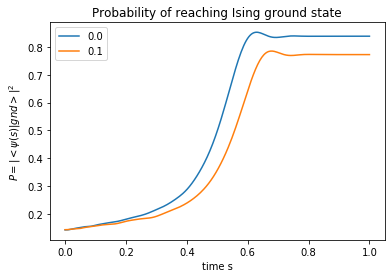

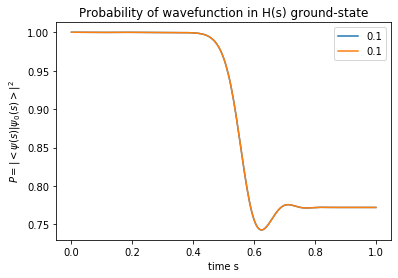

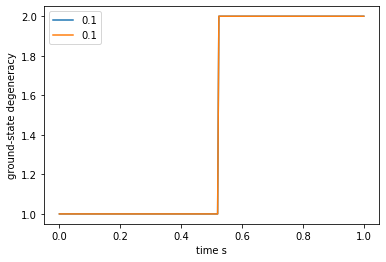

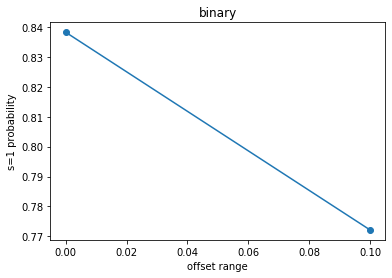

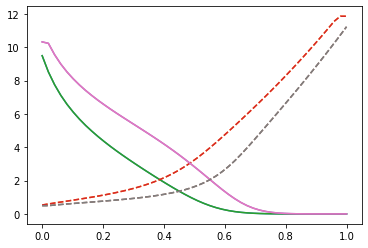

In [3]:
result = dict()
proba = dict()
proba_annealH = dict()
degen_number = dict()
plt.figure("prob(s)")
ax = plt.axes()
for offset_min in offset_min_list:
    with open(f"../qlp/mds/tdse/{embed}_{initial_wavefunction}_{offset}_{offset_min}.pickle", "rb") as file:
        rpickle = pickle.load(file)
        offset_range = -2*offset_min
        result[offset_range] = rpickle["tdse"]
        proba[offset_range] = rpickle["overlap"][-1]
        proba_annealH[offset_range] = rpickle["overlap_annealH"][-1]
        degen_number[offset_range] = rpickle["degen_number"]
    ax.errorbar(x=rpickle["sol"].t, y=rpickle["overlap"], label=offset_range)
ax.legend()
ax.set_xlabel('time s')
ax.set_ylabel(r'$P= |<\psi (s) | gnd >|^2$')
plt.title('Probability of reaching Ising ground state')
plt.show()

plt.figure("annealH prob(s)")
ax = plt.axes()
for offset_min in offset_min_list:
    ax.errorbar(x=rpickle["sol"].t, y=rpickle["overlap_annealH"], label=offset_range)
ax.legend()
ax.set_xlabel('time s')
ax.set_ylabel(r'$P= |<\psi (s) | \psi_0(s) >|^2$')
plt.title('Probability of wavefunction in H(s) ground-state')
plt.show()

plt.figure("degeneracy number")
ax = plt.axes()
for offset_min in offset_min_list:
    ax.errorbar(x=rpickle["sol"].t, y=rpickle["degen_number"], label=offset_range)
ax.legend()
ax.set_xlabel('time s')
ax.set_ylabel(r'ground-state degeneracy')
plt.show()

plt.figure("prob final")
ax=plt.axes()
ax.errorbar(x=list(proba.keys()), y=list(proba.values()), marker="o")
ax.set_xlabel('offset range')
ax.set_ylabel('s=1 probability')
plt.title(offset)
plt.show()

# plot last anneal schedule
plt.figure()
ax = plt.axes()
X = np.linspace(*normalized_time)
yA = np.array([tdse.AS.A(Xi) for Xi in X])
yB = np.array([tdse.AS.B(Xi) for Xi in X])
for qubit in range(len(yA[0])):
    ax.errorbar(x=X, y=yA[:, qubit])
    ax.errorbar(x=X, y=yB[:, qubit], ls='--')

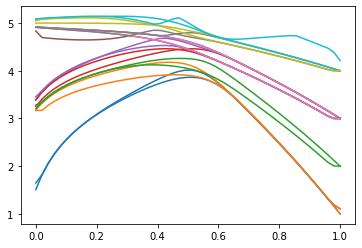

ground state energy: 1.1062598584952061
1st ex state energy: 1.106259858495251
ground state eigvec: [ 0. -0. -1. -0. -0. -0. -0.  0. -0. -0. -0.  0. -0.  0.  0. -0.]
1st ex state eigvec: [ 0. -0. -0.  0.  0. -0. -0.  1.  1. -0.  0. -0.  0. -0.  0.  0.]


In [4]:
# unit conversion
# sol.y = [GHz / h]
make_dimensionless = 1/energyscale * 1/tdse.AS.B(normalized_time[1])[0]

fig = plt.figure()
ax = plt.axes()
num_es = 10
gap = dict()
for key in result.keys():
    x = []
    y = {es: [] for es in range(num_es)}
    for s in np.linspace(normalized_time[0], normalized_time[1]):
        eigval, eigvec = eigh(result[key].annealingH(s))
        seigval = np.sort(eigval)*make_dimensionless + ising_params['c'] + qubo_constant
        x.append(s)
        for es in y.keys():
            y[es].append(seigval[es])
    for es in y.keys():
        ax.errorbar(x=x, y=y[es])
    gap[key] = {es: np.array(y[es]) - np.array(y[0]) for es in y.keys()}
plt.draw()
plt.show()
print("ground state energy:", y[0][-1])
print("1st ex state energy:", y[1][-1])
eigval, eigvec = eigh(result[key].annealingH(s))
print("ground state eigvec:", np.round(eigvec[0]))
print("1st ex state eigvec:", np.round(eigvec[1]))


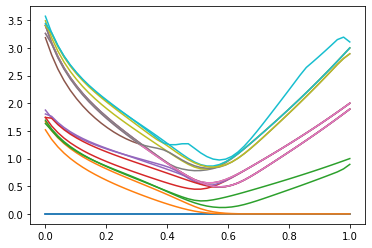

In [6]:
fig = plt.figure()
ax = plt.axes()
for key in gap.keys():
    for es in gap[key].keys():
        ax.errorbar(x=x, y=gap[key][es], label=es)
#ax.legend()
plt.draw()
plt.show()
#print(f"e1-e0 gap[offset_range={min(gap.keys())}][{sum(mask)}]:", gap[min(gap.keys())][sum(mask)][-1])
#print(f"e2-e0 gap[offset_range={min(gap.keys())}][{sum(mask)+1}]:", gap[min(gap.keys())][sum(mask)+1][-1])

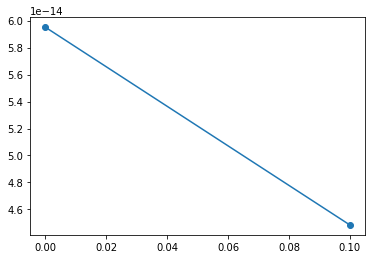

{0.0: 5.950795411990839e-14, 0.1: 4.4853010194856324e-14}

In [7]:
mingap = {key: min(gap[key][1]) for key in gap.keys()}
plt.figure()
ax = plt.axes()
x = list(mingap.keys())
y = list(mingap.values())
ax.errorbar(x=x, y=y, marker="o")
plt.draw()
plt.show()
mingap

In [ ]:
sol.t